# Topic Modelling

In general, topic modeling will serve us to cluster texts that are similar to one another. Why might we want this? That is because when getting data from the Internet, we will usually have quite a big number of texts. It will be very ineffective to read all of them. Instead, we might want to read just a few from each group to understand what are the different types of texts (narratives). For example, it is probably relatively easy to gather texts about the climate emergency. However, the question is in what context it is described, and whether this context has changed over the years or not. Or maybe we want to see whether there are different narratives present in the gathered corpus.

<center><img src="png/topic_modeling.png" width = 600/></center>

If everything goes according to the plan, under topic modeling we will discuss three models:

1. `tf-idf` (term frequency - inverse document frequency) -- a very simple model that will allow us to find similarities between texts.
2. `LDA` (Latent Dirichlet Allocation) -- model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar.
3. `BERTopic` -- a new approach to topic modeling that uses the latest advances in transformers-based machine learning for Natural Language Processing.

However, before we start with anything fancy let's start with the basics and define some key concepts that will serve us in our [voyage](https://www.youtube.com/watch?v=NlgmH5q9uNk) with topic modeling.

1. `Document` -- some text.
2. `Corpus` -- a collection of documents (texts).
3. `Vector` -- a mathematical representation of a document (text).
4. `Model` -- an algorithm for transforming vectors from one representation to another.

## Document

A document is basically a string that might be the length of a single tweet or [A Litle Life](https://en.wikipedia.org/wiki/A_Little_Life). In _Python_ it will look more or less like what we could have expected. Below, we have the text of the last tweet by [Paulo Coelho Quotes](https://www.youtube.com/watch?v=dQw4w9WgXcQ) account:

In [ ]:
document = "Fear of failure leads to failure."

## Corpus

On the other hand, a corpus is a collection of documents (texts). For us, they will play two roles:

1. They are the input for training a model. This is going to be our main use case because among others it will allow for separating common themes and topics.
2. They organize documents. After training, a topic model can be used to extract topics from new documents (documents not seen in the training corpus). In other words, using the trained model we will be able to say how similar is a new document to a group of documents from our corpus.

At this point, we can think about a corpus as a list of strings. Consider the following. These are the 20 last tweets by [Paulo Coelho Quotes](https://twitter.com/PauloCoelho_DQ). We could have imported them to _Python_ in a more efficient way than this but at this point, this is not important.

In [ ]:
text_corpus = [
    "Fear of failure leads to failure.",
    "If we do not face our fears, our fears will chase us forever.",
    "Be brave. Take risks. Nothing can substitute experience.",
    "Rumors are created by haters, spread by fools, and accepted by idiots.",
    "Love yourself first because this is the person you are going to spend the rest of your life with.",
    "The distance between dreams and reality is called discipline.",
    "Never underestimate the power of stupid people.",
    "If you are never alone, you cannot know yourself.",
    "Whatever you decide to do, make sure it makes you happy.",
    "The more violent the storm, the quicker it passes.",
    "If you are never alone, you cannot know yourself.",
    "If you want to be successful, you must respect one rule – Never lie to yourself.",
    "First it hurts, then it changes us.",
    "No matter how you feel today, get up, dress up and show up.",
    "Listen to your heart. It knows all things.",
    "Remember that wherever your heart is, there you will find your treasure.",
    "Never explain. Your friends will not need it. And haters will continue to hate.",
    "The secret of life, though, is to fall seven times and to get up eight times.",
    "We do not need to explain our love. We only need to show it.",
    "Better to be crazy and happy than normal and bitter."
]

**Important**: The above example loads the entire corpus into memory. In practice, corpora may be very large, so loading them into memory may be inconvenient (to say at least). However, for now, we are leaving it as it is.

Before we move any further, we need to tokenize our corpus and also remove stop words. We may just use the same code we discussed when we computed the sentiment.

Therefore, let's start with loading relevant modules and downloading stop words for English.

In [ ]:
## Import NLTK module
import nltk
## Import stop words
from nltk.corpus import stopwords
## Import function to tokenize text
from nltk.tokenize import word_tokenize

## Download stopwords list
nltk.download('stopwords')
nltk.download('punkt')

## Assign the list of English stop words to stop_words
stop_words = stopwords.words('english')


Now, we need to tokenize the texts and remove stop words. We are going to do it in one step using list comprehension because it is just the most convenient solution.

In [ ]:
## Tokenize every single text. Meanwhile remove tokens
## that are shorter than 2 and are in stop_words list
texts = [ [ token for token in word_tokenize(doc.lower()) if token not in stop_words and len(token) > 1 ] 
          for doc in text_corpus ]


Let's create a mapping with the frequency of all words in the corpus. We know how to do it but let's discover a new way of doing it. Instead of using a built-in mapping, we are going to use a more fancy one. The difference is that it does not return an error when a given key does not exist. Instead, it creates a new pairing with the given key and default value. In other words, if we define new mapping as follows:

In [ ]:
## A new type of dictionary
from collections import defaultdict

new_mapping = defaultdict(int)

and try to access its non-existing key, let's say `'name'`

In [ ]:
new_mapping['name']

it returned `0` because we initialized it with a default value to `int` which is understood as `0`. What's more, when we inspect the mapping, we see that a new pairing appeared.

In [ ]:
new_mapping

So it not only did not return an error. It also created a new pairing. This is pretty cool, right? Mostly because we don't have to write any more code like the following to compute the frequency of tokens.

In [ ]:
## Create an empty mapping.
frequency = {}

## Compute the frequency of tokens in the whole
## corpus.
for text in texts:
    for token in text:
        if token in frequency:
            frequency[token] += 1
        else:
            frequency[token] = 1
        

In [ ]:
## Create an empty fancy mapping.
frequency = defaultdict(int)

## Count the number of words all texts
for text in texts:
    for token in text:
        frequency[token] += 1

Clearly, both methods return the same results.

Ok, now let's use the frequency mapping to remove from our corpus words that appear only once. For our purposes, they are not going to be very useful because we will not be able to infer from them whether the two documents are similar. Again, we are going to use list comprehension for that.

In [ ]:
## Remove tokens that appear only once in the whole corpus
processed_corpus = [ [ token for token in text if frequency[token] > 1 ] 
                     for text in texts ]

processed_corpus

Before proceeding, we will associate each word in the corpus with a unique integer ID. We want to do this because for a computer it will be just easier to use integers than strings (basically a string consumes more space than an integer, therefore, the computer can operate on integers faster than on string). We will use for that a new module `gensim`. It will allow for the creation of a dictionary that will store unique tokens paired with a unique integer id. In other words, we will create a kind of mapping. We can think about it a bit like a dictionary with integers as keys and tokens as values.

In [ ]:
## Import gensim
from gensim import corpora

## Create a new object called Dictionary
dictionary = corpora.Dictionary(processed_corpus)

## Let's print it out
print(dictionary)

As you see it is not a mapping per se. But we can easily convert it to an ordinary mapping by iteraiting over it.

In [ ]:
{ key : value for key, value in dictionary.items() }

**NOTE**: We have here a relatively small corpus, therefore, there are only 17 different tokens. For a larger corpus, dictionaries can become massive, like over a thousand tokens. Among others, this is why it is not an ordinary dictionary but stores the data in a more efficient and memory-friendly way. The other property of this Dictionary is that we don't have to have all documents in the working memory at the same time to create it. There is an easy way to create it by processing one document at a time. However, we are not going to discuss it right now because right now we focus on the general idea.

## Vector

What happened so far was relatively easy. More or less we converted a set of texts into a new object which is called Dictionary (it is not the same as `dict` or a mapping). Now, we would like to convert the tokens we have into vectors. We need that because to infer the latent structure in our corpus we need a way to represent documents in a way that allows for mathematical manipulation. In other words, we need to transform strings that are understandable for us into something which will be understandable for a computer. We can infer the latent structure (find similarities between texts) by understanding the meaning of the texts but computers can not really do that (don't believe people who state otherwise). Instead, they can quite well and fast perform mathematical operations. Therefore, we need a way to convert a text into a mathematical object (vector) and ask the computer to find similarities between a set of vectors using math (you probably computed the distance between two vectors in high school).

In other words, we need to find a way to represent a document (text) as a vector of features. For example, a single feature may be thought of as a question-answer pair:

1. How many times does the word *sponge* appear in the document? Zero.
2. How many paragraphs does the document consist of? Two.
3. How many fonts does the document use? Five.

If we are going to apply the same questions to every single text we can skip their text and only refer to their integer ids (such as `1`, `2`, and `3`). Therefore, the representation of a document becomes a series of pairs like `(1, 0), (2, 2), (3, 5)`. This is called a **dense vector**, because it contains an explicit answer to each of the above questions.

In practice, we can omit `0` values. We do that to save memory (usually we have much more features than just `3`). Therefore, actually, our vector would look like `(2,2), (3,5)`. This is known as a **sparse vector** or **bag-of-words vector**.

Assuming the questions are the same we can compare two texts, for example, texts with the following **bag-of-words** vectors `(2, 2), (3, 5)` and `(1, 1), (2, 2), (3, 5)`. Based on the answers to our questions we can infer that the two texts must be similar. The only difference between these two texts is the appearance of [sponge](https://www.youtube.com/watch?v=-SuSWX8h-hg). They must be similar, at least on the examined features. We don't have to do any heavy math to examine it.

Ok, so let's have something more involving than our silly questions. Usually, under the **bag-of-words** models, each document is represented by a vector containing the frequency count of each word in the dictionary. For example, let's assume we have a dictionary containing the following words `['sponge', 'square', 'pants', 'bob']`. A document consisting of the string `"sponge pants sponge"` would then be represented by the vector `(1, 2), (2, 0), (3, 1), (4, 0)`, where the entries of the vector are (in order) the occurrences of "sponge", "square", "pants", and "bob" in the document. The only issue here is that we kind of ignored the order of words. But let's don't worry about it right now. Also, as the name of this method suggests it is a **bag-of-words** approach so it is understandable that the order does not matter too much.

Ok, it is all very good but how it connects with the creation of this Dictionary object? This is somehow exactly this. Our processed corpus has `17` unique tokens in it, which means that each document will be represented by a 17-dimensional vector under the **bag-of-words model**. We can use the dictionary to turn tokenized documents into these 17-dimensional vectors. Let's see these ids again using the `token2id` method:

In [ ]:
dictionary.token2id

So now, when we want to vectorize a phrase we will just use the above dictionary as a kind of cipher. For example, suppose we want to vectorize the phrase [`"If you do not fight for your love what kind of love do you have?"`](https://youtu.be/jFrGYB8inoY) (note that this phrase was not in our original corpus, however, is equally cheesy). We can create the **bag-of-word** representation for a document using the `doc2bow()` method of the dictionary, which returns a sparse representation of the word counts:

In [ ]:
new_doc = "If you do not fight for your love what kind of love do you have?"
new_vec = dictionary.doc2bow(word_tokenize(new_doc.lower()))
new_vec

The first entry in each tuple corresponds to the ID of the token in the dictionary, the second corresponds to the count of this token.

Note that this vector only contains entries for words that actually appeared in the document. Because any given document will only contain a few words out of the many words in the dictionary, words that do not appear in the vectorization are represented as implicitly zero as a space-saving measure.

We can convert our entire original corpus to a list of vectors:

In [ ]:
bow_corpus = [ dictionary.doc2bow(text) for text in processed_corpus ]
bow_corpus

**NOTE**: In our specific case we can have the whole list in the working memory but with more (and longer) documents we will not want to load all the elements at the same time. Luckily, `gensim` allows you to use any iterator that returns a single document vector at a time but we are not going to talk about it right now.

**IMPORTANT**: The distinction between a document and a vector is that the former is text, and the latter is a mathematically convenient representation of the text. Moreover, depending on how the representation was obtained, two different documents may have the same vector representations.


## Model

Before, we talk about more involving models. Let's start with the simplest transformation. So far, we have vectorized our corpus. Now, we can transform the **bag-of-words** representation into something more interesting.

One simple example of a model (transformation) is `tf-idf` (term frequency - inverse document frequency). In simple words, it returns a statistic that allows saying how important a given term is to a document in the corpus, for example how important Sirius Black is to the Harry Potter book in the collection of Harry Potter books. Therefore, this model allows for transforming vectors from the **bag-of-words** representation to a vector space where the frequency counts are weighted according to the relative rarity of each word in the corpus. Why it is useful? That is because this statistic lays the foundations for the relevance of the search.

Imagine that you have a set of Harry Potter books and you would like to order them by the relevance to the following query: "Sirius Black". A simple way to start out is by eliminating books that do not contain all two words "Sirius Black", but this still leaves many books (probably 7). To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, the problem often arises when the texts differ in terms of length (and if you read Harry Potter books you probably noticed that each book was longer than the previous one). Therefore, we can simply divide the number of occurence of a given word ($i$) in a given document ($j$) by the number of all words:

$$frequency_{i,j} = \frac{i_j}{n_j}$$

where, $i$ is a given word (token); $j$ is a given document; and $n_j$ is the number of words (tokens) in the document $j$.

Because the term "Black" is so common, term frequency will tend to incorrectly emphasize documents that happen to use the word "Black" more frequently, without giving enough weight to the more meaningful term "Sirius". The term "Black" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common word "Sirius". Hence, an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely. In other words, "Black" is not a very specific word for our corpus. It appears in all texts very often. On the other hand, "Sirius" is more unique because it appears less often in texts, therefore, we can think about it as more important for our corpus. In other words, if the term "Sirius" appears in our text than the probability that it is a text we have been looking for is higher.

In our case, we will compute tf-idf model simply according to the following equation:

$$tf{-}idf_{i,j} = frequency_{i,j} \times log_2(\frac{D}{document\_freq_i})$$

where, $frequency_{i,j}$ is frequency of a term $i$ in document $j$; $D$ is a number of documents in the corpus; and $document\_freq_i$ is the number of documents with the term $i$.

In [ ]:
## Import models from gensim
from gensim import models

## Train the model. In other words, compute
## the tf-idf statistic for each term.
tfidf = models.TfidfModel(bow_corpus)

Ok, this is pretty cool but how exactly check what are the tf-idf scores for each term? Let's start by reminding ourselves of all the tokens we have and their frequency in the whole corpus.

In [ ]:
## We simply look into frequency mapping. 
## The only thing is that we remove the elements
## that appeared only once. 
{ key : value for key, value in frequency.items() if value > 1 }

Now, let's examine the documents' frequency. In other words, in how many documents a given term appeared.

In [ ]:
## We can extract it from our model
tfidf.dfs

This does not help much because the keys here are these unique ids. Let's do something more useful and convert the ids back to words. Unlike computers, it matters to us whether we have a number or a word.

In [ ]:
## We iterate over dictionary and take id and token and convert
## tfidf.dfs into human-readable format.
{ token : tfidf.dfs[id] for id, token in dictionary.items() }

What we can see is that for example word "fears" appears 2 times in the whole corpus but only in 1 documents while for example "love" appears 2 times but each time in different document. In other words, word "love" is not a very specific word for a document while fears is.

So far so good. Let's now see idf for each word. In other words:

$$idf_i = log_2(\frac{D}{document\_freq_i})$$

In [ ]:
## We iterate over dictionary and take id and token and convert
## tfidf.dfs into human-readable format.
{ token : tfidf.idfs[id] for id, token in dictionary.items() }

Finally, let's see the `tf-idf` for given terms.

In [ ]:
## transform the "first love" string
words = "First times".lower().split()

print(tfidf[dictionary.doc2bow(words)])

The ``tfidf`` model again returns a list of tuples, where the first entry is the token ID and the second entry is the tf-idf weighting. Note that the ID corresponding to "first" (which occurred 2 times in the original corpus) has been weighted lower than the ID corresponding to "times" (which also appeared twice but in the same document). In other words, `tf-idf` provides the inromation whether a given term allows to identify a document or is somehow spread across all documents. 

Once you've created the model, you can do all sorts of cool stuff with it. For example, to transform the whole corpus via TfIdf and index it, in preparation for similarity queries:

In [ ]:
## Import a similarities measure
from gensim import similarities

## Compute cosine similarity measure. Baisically, it is a cosine between
## two vectors.
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=17)

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [ ]:
## Provide a document to chekc the similarity
query_document = word_tokenize('Do not fear to love for the first time.'.lower())

## Convert the query document to a Bag of words representation
query_bow = dictionary.doc2bow(query_document)

## Compute the similarities between a query_document and corpus documents
sims = index[tfidf[query_bow]]

## Print out the results
print(list(enumerate(sims)))

How to read this output? Document 4 has a similarity score of 0.8165=82%, document 12 has a similarity score of 50% etc. We can make this slightly more readable by sorting:

In [ ]:
## Print out the results in the descending order
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(text_corpus[document_number], score)

## LDA (Latent Dirichlet Allocation Model)

In simple terms Latent Dirichlet Allocation models are a way of automatically discovering topics in the given corpus. For example, imagine you have the following set of sentences (in real-world we would operate on documents that contain multiple sentences).

* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chinchillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli.

The LDA model returns more or less the following information about the probability to belong each sentence to a topic.

* **Sentences 1 and 2**: 100% Topic A
* **Sentences 3 and 4**: 100% Topic B
* **Sentence 5**: 60% Topic A, 40% Topic B

And the most representative words for a topic.
* **Topic A**: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, etc. (at which point, you could interpret topic A to be about food)
* **Topic B**: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, etc. (at which point, you could interpret topic B to be about cute animals)

### This is fun but how does it happen?

First, LDA makes assumptions about how the documents are created. It sees each document as a mixutere of topics that spit out words with certain probabilities. Therefore, it assumes that each document is created in the following fashion.

1. Decide on the number of words `N` the document will have.
2. Choose a topic mixture for the document. For example, assuming that we have the two food and cute animal topics above, you might choose the document to consist of $\frac{1}{3}$ food and $\frac{2}{3}$ cute animals.
3. Generate each word $w_i$ in the document by:
	- First picking a topic (according to the multinomial distribution that you sampled above; for example, you might pick the food topic with 1/3 probability and the cute animals topic with 2/3 probability).
	- Using the topic to generate the word itself (according to the topic’s multinomial distribution). For example, if we selected the food topic, we might generate the word “broccoli” with 30% probability, “bananas” with 15% probability, and so on.

Assuming this generative model for a collection of documents, LDA then tries to backtrack from the documents to find a set of topics that are likely to have generated the collection.

### Example

According to the above process, when generating some particular document D, you might

1. Pick 5 to be the number of words in D.
2. Decide that D will be 1/2 about food and 1/2 about cute animals.
3. Pick the first word to come from the food topic, which then gives you the word `"broccoli"`.
4. Pick the second word to come from the cute animals topic, which gives you `"panda"`.
5. Pick the third word to come from the cute animals topic, giving you `"adorable"`.
6. Pick the fourth word to come from the food topic, giving you `"cherries"`.
7. Pick the fifth word to come from the food topic, giving you `"eating"`.

So the document generated under the LDA model will be `"broccoli panda adorable cherries eating"` (note that LDA is a bag-of-words model).

### Learning

This is all very good, let's assume that we have generated a set of similar documents. You’ve chosen some fixed number of K topics to discover, and want to use LDA to learn the topic representation of each document and the words associated to each topic. How do you do this? One way (known as collapsed Gibbs sampling) is the following:

Go through each document, and randomly assign each word in the document to one of the K topics. Notice that this random assignment already gives you both topic representations of all the documents and word distributions of all the topics (albeit not very good ones).

So how to improve this topics?

Go through each word w in `d` and for each topic `t`, compute two things: 

1) $p(topic_t | document_d)$ -- the proportion of words in document `d` that are currently assigned to topic `t`. 
2) $p(word_w | topic_t)$ -- the proportion of assignments to topic `t` over all documents that come from this word `w`. 

Reassign `w` a new topic, where we choose topic `t` with probability $p(topic_t | document_d) \times p(word_w | topic_t)$ (according to our generative model, this is essentially the probability that topic `t` generated word `w`, so it makes sense that we resample the current word’s topic with this probability). In other words, in this step, we’re assuming that all topic assignments except for the current word in question are correct, and then updating the assignment of the current word using our model of how documents are generated.

After repeating the previous step a large number of times, you’ll eventually reach a roughly steady state where your assignments are pretty good. So use these assignments to estimate the topic mixtures of each document (by counting the proportion of words assigned to each topic within that document) and the words associated to each topic (by counting the proportion of words assigned to each topic overall).


### Real-world example

This is all very good but how to do it in practice. The good news is that it is quite easy in _Python_. What we need is a corpus of texts. Let's use the same corpus we used in the article on [The effect of the pandemic on European narratives on smart cities and surveillance](https://doi.org/10.1177/00420980221138317).

In [41]:
import json
# Import NLTK module
import nltk
## Import stop words
from nltk.corpus import stopwords
## Import function to tokenize text
from nltk.tokenize import word_tokenize
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
# Remove rare and common tokens.
from gensim.corpora import Dictionary
# Train LDA model.
from gensim.models import LdaModel

import matplotlib.pyplot as plt

## Download stopwords list
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## Assign the list of English stop words to stop_words
stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikolaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mikolaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mikolaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
with open('LDA.jl', 'r') as file:
    df = [ json.loads(line) for line in file.readlines() ]

With the corpus of texts. We will need to preprocess it a bit. It will involve 3 steps (this is a very naive way of preprocessing the corpus but for our purposes it is more than enough).

1. Tokenize the text.
2. Lemmatize the tokens.
3. Compute the bag-of-words representation of the data.

In [17]:
## Tokenize every single text. Meanwhile remove tokens
## that are shorter than 2 and are in stop_words list
list_tokens = [ [ token for token in word_tokenize(doc['content'].lower()) if token not in stop_words and len(token) > 1 ] 
          for doc in df ]


In [22]:
list_lemmas = [[lemmatizer.lemmatize(token) for token in doc] for doc in list_tokens]

In [25]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(list_lemmas)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [26]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in list_lemmas]

In [27]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 841
Number of documents: 184


In [30]:
# Set training parameters.
num_topics = 7
passes = 100
iterations = 1000
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

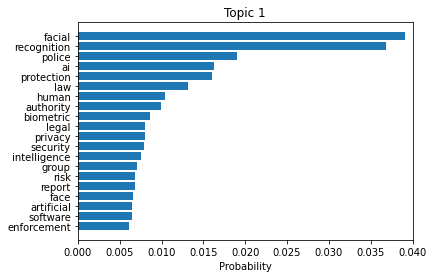

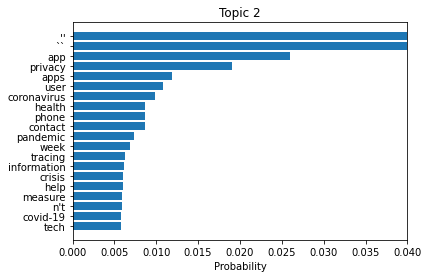

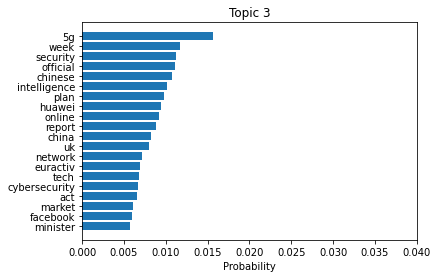

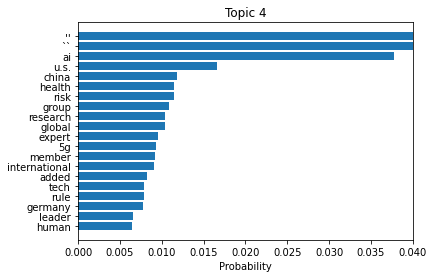

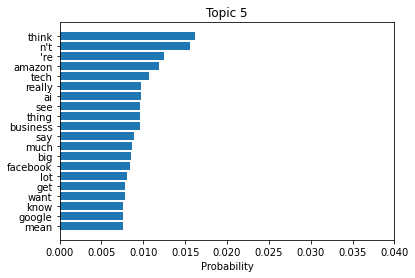

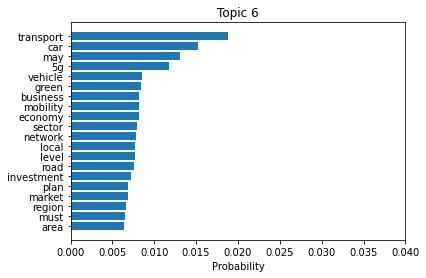

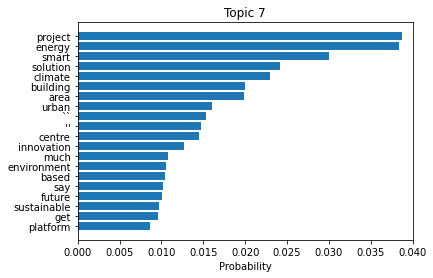

In [42]:
list_top_tokens = [ { key : value for value, key in t[0] } for t in model.top_topics(corpus) ]

for i in range(len(list_top_tokens)):
    plt.barh(list(list_top_tokens[i].keys()), list(list_top_tokens[i].values()), align = 'center')
    plt.xlim(0,.04)
    plt.gca().invert_yaxis()
    plt.title('Topic' + ' ' + str(i + 1))
    plt.xlabel('Probability')
    plt.show()

In [48]:
df_topics = []
for line in zip(df, [ sorted( model.get_document_topics(doc), key = lambda x: x[1], reverse=True )[0] for doc in corpus ]):
    temp_dict = line[0]
    temp_dict['topics'], temp_dict['prob'] = line[1]
    df_topics.append(temp_dict)